In [105]:
#!/usr/bin/env python

# make sure to install necessary packages before running

import os
import sys
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sodapy import Socrata

# NYPD Arrest Data (Year to Date)
socrata_dataset_identifier = 'uip8-fykc'
socrata_domain = 'data.cityofnewyork.us'

# read application token
with open('app-token.txt', 'r') as fp:
    contents = fp.read()
socrata_token = contents

# connect to data
client = Socrata(socrata_domain, socrata_token)

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
#client = Socrata("data.cityofnewyork.us", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata('data.cityofnewyork.us',
#                  MyAppToken,
#                  username="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
# results = client.get(socrata_dataset_identifier, limit=1000)

# Convert to pandas DataFrame
# results_df = pd.DataFrame.from_records(results)

In [106]:
# Metadata
metadata = client.get_metadata(socrata_dataset_identifier)
metadata_columns = [x['name'] for x in metadata['columns']]
metadata_columns

['ARREST_KEY',
 'ARREST_DATE',
 'PD_CD',
 'PD_DESC',
 'KY_CD',
 'OFNS_DESC',
 'LAW_CODE',
 'LAW_CAT_CD',
 'ARREST_BORO',
 'ARREST_PRECINCT',
 'JURISDICTION_CODE',
 'AGE_GROUP',
 'PERP_SEX',
 'PERP_RACE',
 'X_COORD_CD',
 'Y_COORD_CD',
 'Latitude',
 'Longitude']

In [118]:
# Metadata for a particular column
meta_arrest_date = [x for x in metadata['columns'] if x['name'] == 'ARREST_DATE'][0]
meta_arrest_date

{'id': 380202915,
 'name': 'ARREST_DATE',
 'dataTypeName': 'calendar_date',
 'description': 'Exact date of arrest for the reported event',
 'fieldName': 'arrest_date',
 'position': 2,
 'renderTypeName': 'calendar_date',
 'tableColumnId': 65692457,
 'cachedContents': {'largest': '2019-09-30T00:00:00.000',
  'non_null': 131043,
  'null': '0',
  'top': [{'item': '2019-05-02T00:00:00.000', 'count': '888'},
   {'item': '2019-04-17T00:00:00.000', 'count': '874'},
   {'item': '2019-01-10T00:00:00.000', 'count': '856'},
   {'item': '2019-01-23T00:00:00.000', 'count': '838'},
   {'item': '2019-07-24T00:00:00.000', 'count': '837'},
   {'item': '2019-04-03T00:00:00.000', 'count': '834'},
   {'item': '2019-04-10T00:00:00.000', 'count': '815'},
   {'item': '2019-04-24T00:00:00.000', 'count': '810'},
   {'item': '2019-08-14T00:00:00.000', 'count': '809'},
   {'item': '2019-01-03T00:00:00.000', 'count': '808'},
   {'item': '2019-03-13T00:00:00.000', 'count': '806'},
   {'item': '2019-05-01T00:00:00.0

In [124]:
# get date range of data
# note: string is returned
most_recent_date = meta_arrest_date['cachedContents']['largest']
oldest_date = meta_arrest_date['cachedContents']['smallest']
num_of_results = int(meta_arrest_date['cachedContents']['not_null'])
# print(most_recent_date)
# print(oldest_date)
print("Total number of not-null results: "+ str(num_of_results))

Total number of not-null results: 167965


In [125]:
# loop through the results

loop_size = 10000
num_loops = math.ceil(num_of_results/loop_size)

data = []

for i in range(num_loops):
    results = client.get(socrata_dataset_identifier, 
                         where="ARREST_DATE >= '2019-01-01T00:00:00.000'",
                         # select="column1,column2,etc",
                         # order="column1 ASC",
                         # can also do other operations 
                         limit=loop_size,
                         offset=loop_size * i)
    data.extend(results)
    #print("Loop number: " + str(i))

In [127]:
results_df = pd.DataFrame(data)
results_df.head()

,age_group,arrest_boro,arrest_date,arrest_key,arrest_precinct,jurisdiction_code,ky_cd,latitude,law_cat_cd,law_code,longitude,ofns_desc,pd_cd,pd_desc,perp_race,perp_sex,x_coord_cd,y_coord_cd
0,25-44,M,2019-09-30T00:00:00.000,203078287,9,0,105.0,40.72420015400007,F,PL 1600500,-73.97722564299994,ROBBERY,397,"ROBBERY,OPEN AREA UNCLASSIFIED",BLACK HISPANIC,M,990563,203120
1,18-24,Q,2019-09-30T00:00:00.000,203072424,113,0,121.0,40.68997415500007,F,PL 1450502,-73.79676854399997,CRIMINAL MISCHIEF & RELATED OF,268,CRIMINAL MIS 2 & 3,BLACK,M,1040611,190715
2,18-24,S,2019-09-30T00:00:00.000,203061215,122,0,347.0,40.60612948000005,M,VTL11920U3,-74.07657042999993,INTOXICATED & IMPAIRED DRIVING,905,"INTOXICATED DRIVING,ALCOHOL",WHITE,M,962989,160112
3,25-44,S,2019-09-30T00:00:00.000,203061218,120,0,105.0,40.645022746000045,F,PL 1601502,-74.077216847,ROBBERY,397,"ROBBERY,OPEN AREA UNCLASSIFIED",WHITE HISPANIC,M,962822,174282
4,18-24,Q,2019-09-30T00:00:00.000,203063729,106,0,105.0,40.68426580100004,F,PL 1601001,-73.81513849899994,ROBBERY,397,"ROBBERY,OPEN AREA UNCLASSIFIED",ASIAN / PACIFIC ISLANDER,M,1035521,188624


In [128]:
# unique boroughs
unique_results = results_df.arrest_boro.unique()
print(unique_results)

# unique pd_desc
print()
unique_pd_desc = results_df.pd_desc.unique()
print(len(unique_pd_desc))

print()
print(results_df['arrest_boro'].value_counts())

print()
print(results_df.shape)

print()
print(results_df.dtypes)

['M' 'Q' 'S' 'B' 'K']

254

K    45842
M    41793
B    38309
Q    34864
S     7157
Name: arrest_boro, dtype: int64

(167965, 18)

age_group            object
arrest_boro          object
arrest_date          object
arrest_key           object
arrest_precinct      object
jurisdiction_code    object
ky_cd                object
latitude             object
law_cat_cd           object
law_code             object
longitude            object
ofns_desc            object
pd_cd                object
pd_desc              object
perp_race            object
perp_sex             object
x_coord_cd           object
y_coord_cd           object
dtype: object


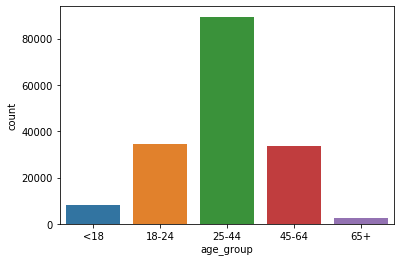

In [129]:
def order_labels(age_group_labels):
    """Returns age_group label sorted in ascending order"""
    ordered_labels = sorted(list(age_group_labels))
    last_item = ordered_labels.pop()
    ordered_labels.insert(0, last_item)
    return ordered_labels
    
age_group_labels = order_labels(results_df.age_group.unique())

sns.countplot(results_df['age_group'],
              order=age_group_labels)

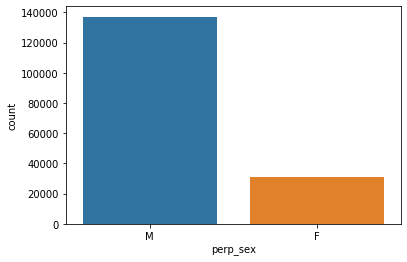

In [130]:
sns.countplot(results_df['perp_sex'],
              )

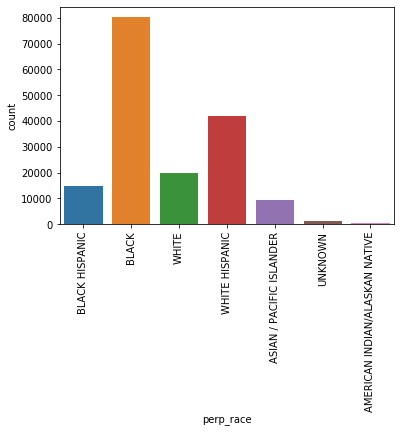

In [132]:
plot_race = sns.countplot(results_df['perp_race'],
             )
tick_labels = plot_race.get_xticklabels()
plot_race = plot_race.set_xticklabels(tick_labels, rotation=90)

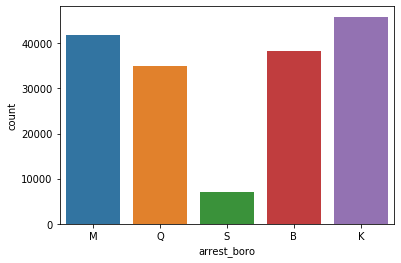

In [133]:
sns.countplot(results_df['arrest_boro'],
              )

In [139]:
# export Pandas DataFrame to csv
from datetime import date
today = date.today()

results_df.to_csv(f"{today}_nypd-arrests.csv", index_label="unique_id")